# Sunspots : Modelo de red neuronal recurrente utilizando series temporales

![gif sunspots](https://www.spaceweatherlive.com/images/help/zonnevlekken_magnetisch/beta-gamma-delta_1.jpg)

> **nombre:** Bryam David Vega Moreno <br>
> **maestro:** Rodolfo Bojorque <br>
> **universidad:** Universidad Politécnica Salesiana

--------------
## Introducción: Que es un sunspot?

Las manchas solares son fenómenos temporales en la fotosfera del Sol que aparecen como manchas más oscuras que las áreas circundantes. Son regiones de temperatura superficial reducida causada por concentraciones de flujo de campo magnético que inhiben la convección. Las manchas solares suelen aparecer en pares de polaridad magnética opuesta. Su número varía según el ciclo solar de aproximadamente 11 años.

## Que son las redes neuronales recurrentes?

Las redes neuronales recurrentes, o Recurrent Neural Networks(RNN) en inglés, son una clase de redes para analizar datos de series temporales permitiendo tratar la dimensión de “tiempo”, que hasta ahora no habíamos considerado con las redes neuronales vistas en capítulos anteriores.


## Que son las series temporales?

Una serie temporal se define como una colección de observaciones de una variable recogidas secuencialmente en el tiempo. Estas observaciones se suelen recoger en instantes de tiempo equiespaciados. Si los datos se recogen en instantes temporales de forma continua, se debe o bien digitalizar la serie, es decir, recoger sólo los valores en instantes de tiempo equiespaciados, o bien acumular los valores sobre intervalos de tiempo


# Preparación de datos

El conjunto de datos que estmos utilizando proviene de la plataforma Kaggle, el dataset se denomina <a href="https://www.kaggle.com/robervalt/sunspots">Sunspots</a>. Este dataset contiene el número total medio mensual de manchas solares desde **31/01/1749** hasta **31/07/2018**. El objetivo de esta sección es realizar una limpieza a nuestro pequeño conjunto de datos con la finalidad de tenerlo listo para pasar dichos datos a nuestro modelo de red neuronal.

## Importamos librerías

En esta sección importamos las librerias necesarias para realizar nuestro trabajo. Esta sección contiene las librerias para realizar: **preprocesamiento, gráficos, arquitectura de red neuronal** y por ultimo cuenta con una pequeña libreria para evitar warnings.

In [12]:
### Librerias para pre procesamiento
import datetime as dt
import numpy as np
import pandas as pd


from sklearn.preprocessing import MinMaxScaler


## Librerias para la realización de graficos
import matplotlib.pyplot as plt

# Libreria para las redes neuronales
import tensorflow as tf

## Libreria para ignorar warnings
import warnings
warnings.filterwarnings("ignore")

## Lectura de datos

Mediante la libreria pandas procedemos a leer el conjunto de datos de sunspots.

In [8]:
df = pd.read_csv('./data/Sunspots.csv')
df.head()

,day,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


## Verificamos si tenemos valores nulos

Una buena práctica,antes de realizar todo nuestro preprocesamiento es verificar si tenemos datos nulos, ya que estos pueden afectar gravemente a nuestro conjunto de datos.

In [9]:
df.isna().sum()

day                                  0
Date                                 0
Monthly Mean Total Sunspot Number    0
dtype: int64

## Obtenemos los datos para la serie

Tomando en cuenta que tenemos una columna que tiene los valores de salida, creamos una serie con la misma tomando en cuenta los valores de la columna día, para ello creamos un array para cada uno de ellos.

In [10]:
sunspots = df['Monthly Mean Total Sunspot Number']
series = np.array(sunspots)
time = np.arange(0, 3235)

## Procesamiento para series temporales utilizando ventanas

Para este procesamiento se va a seguir un conjunto de pasos, entre los cuales podrían estar la definición de parametros previo a nuestra red neuronal, nuetro conjunto de entrenamiento de train y test.

### Definir parametros

En este paso solamente definiremos los datos del tamaño de ventana, así como también el batch y shuffle size para nuestro modelo de red neuronal

In [11]:
window_size = 100
batch_size = 256
shuffle_buffer_size = 1000

### Obtener conjunto de datos de entrenamiento

Obtenemos los datos de entrenamiento tomando en cuenta la tamaño de la ventana, batch y shuffle de nuestro modelo de red. Para ello se crea un método que permite obtener los datos en formato de serie.

In [13]:
def train_data_pipeline(series, window_size, batch_size, shuffle_buffer_size):
    series = tf.expand_dims(series, axis=-1)
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size+1, shift=1, drop_remainder=True)
    data = data.flat_map(lambda w: w.batch(batch_size))
    data = data.shuffle(shuffle_buffer_size)
    data = data.map(lambda w: (w[:-1], w[1:]))
    return data.batch(batch_size).prefetch(1)
    
train = train_data_pipeline(series, window_size, batch_size, shuffle_buffer_size)

### obtener conjunto de datos de prueba

Realizamos el mismo proceso pero ahora tomando en cuenta el conjunto de prueba.

In [17]:
def test_data_pipeline(series):
    series = tf.expand_dims(series, axis=-1)
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda w: w.batch(window_size))
    data = data.batch(batch_size).prefetch(1)
    return data

test = test_data_pipeline(series)

# Creación del modelo de red neuronal

Para ello procedemos a crear un modelo de red neuronal recurrente, el cual esta combinado con una pequeña capa convolucional ya que al trabajar con ventanas es buena idea realizar un filtrado y mediante dicha capa usando ventanas de suavizado. Luego de ello se realiza una capa LSTM el cual es una capa de red neuronal muy fuerte la cual permitira retroalimentarse con datos secuenciales. Por utlimo capas normales que tendran su función de activación. Por último una capa lambda que es muy util cuando se tienen datos secuenciales.

## Creación de la arquitectura del modelo

In [19]:
tf.keras.backend.clear_session()

# The model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 64)          384       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 32)          2080      
_________________________________________________________________
dense_1 (Dense)              (None, None, 16)          528       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           1

## Entrenamiento del modelo creado

Una vez creado el modelo se procede a entrenar el modelo utilizando un optimizador denominado "adam", el cual es un buen optimizador de red neuronal si tomamos en cuenta las redes convolucionales y recurrentes.

In [21]:
# Compiling and Training the Model
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=["mae"])
history = model.fit(train, epochs=500, verbose=1)

Epoch 1/500
13/13 [==============================] - 8s 336ms/step - loss: 29.0739 - mae: 29.5689
Epoch 2/500
13/13 [==============================] - 5s 355ms/step - loss: 21.3691 - mae: 21.8630
Epoch 3/500
13/13 [==============================] - 5s 361ms/step - loss: 19.4188 - mae: 19.9118
Epoch 4/500
13/13 [==============================] - 5s 365ms/step - loss: 18.7778 - mae: 19.2704
Epoch 5/500
13/13 [==============================] - 5s 364ms/step - loss: 18.1934 - mae: 18.6854
Epoch 6/500
13/13 [==============================] - 5s 353ms/step - loss: 17.9474 - mae: 18.4392
Epoch 7/500
13/13 [==============================] - 5s 357ms/step - loss: 17.3240 - mae: 17.8157
Epoch 8/500
13/13 [==============================] - 5s 367ms/step - loss: 16.8766 - mae: 17.3683
Epoch 9/500
13/13 [==============================] - 5s 385ms/step - loss: 16.9595 - mae: 17.4509
Epoch 10/500
13/13 [==============================] - 5s 376ms/step - loss: 16.6031 - mae: 17.0940
Epoch 11/500
13/13 

13/13 [==============================] - 4s 321ms/step - loss: 10.8971 - mae: 11.3794
Epoch 84/500
13/13 [==============================] - 4s 319ms/step - loss: 10.9301 - mae: 11.4128
Epoch 85/500
13/13 [==============================] - 4s 330ms/step - loss: 10.4717 - mae: 10.9526
Epoch 86/500
13/13 [==============================] - 4s 330ms/step - loss: 10.2551 - mae: 10.7331
Epoch 87/500
13/13 [==============================] - 5s 363ms/step - loss: 10.2605 - mae: 10.7399
Epoch 88/500
13/13 [==============================] - 5s 358ms/step - loss: 10.0983 - mae: 10.5764
Epoch 89/500
13/13 [==============================] - 5s 348ms/step - loss: 10.1072 - mae: 10.5847
Epoch 90/500
13/13 [==============================] - 5s 349ms/step - loss: 9.8289 - mae: 10.3054
Epoch 91/500
13/13 [==============================] - 5s 356ms/step - loss: 9.8583 - mae: 10.3355
Epoch 92/500
13/13 [==============================] - 5s 356ms/step - loss: 10.1030 - mae: 10.5829
Epoch 93/500
13/13 [=====

13/13 [==============================] - 4s 324ms/step - loss: 5.7571 - mae: 6.2188
Epoch 167/500
13/13 [==============================] - 4s 324ms/step - loss: 5.4647 - mae: 5.9187
Epoch 168/500
13/13 [==============================] - 4s 323ms/step - loss: 5.5458 - mae: 6.0013
Epoch 169/500
13/13 [==============================] - 4s 323ms/step - loss: 5.3937 - mae: 5.8472
Epoch 170/500
13/13 [==============================] - 4s 324ms/step - loss: 5.7033 - mae: 6.1618
Epoch 171/500
13/13 [==============================] - 4s 326ms/step - loss: 5.5735 - mae: 6.0367
Epoch 172/500
13/13 [==============================] - 4s 324ms/step - loss: 5.2965 - mae: 5.7509
Epoch 173/500
13/13 [==============================] - 4s 327ms/step - loss: 5.4004 - mae: 5.8557
Epoch 174/500
13/13 [==============================] - 4s 326ms/step - loss: 5.3816 - mae: 5.8383
Epoch 175/500
13/13 [==============================] - 4s 327ms/step - loss: 5.3350 - mae: 5.7880
Epoch 176/500
13/13 [=============

13/13 [==============================] - 4s 330ms/step - loss: 3.9066 - mae: 4.3485
Epoch 250/500
13/13 [==============================] - 4s 330ms/step - loss: 3.6788 - mae: 4.1167
Epoch 251/500
13/13 [==============================] - 4s 327ms/step - loss: 3.6642 - mae: 4.0991
Epoch 252/500
13/13 [==============================] - 4s 328ms/step - loss: 3.6775 - mae: 4.1139
Epoch 253/500
13/13 [==============================] - 4s 327ms/step - loss: 3.7015 - mae: 4.1376
Epoch 254/500
13/13 [==============================] - 4s 325ms/step - loss: 3.5374 - mae: 3.9701
Epoch 255/500
13/13 [==============================] - 4s 330ms/step - loss: 3.6139 - mae: 4.0483
Epoch 256/500
13/13 [==============================] - 4s 330ms/step - loss: 3.6686 - mae: 4.1034
Epoch 257/500
13/13 [==============================] - 4s 330ms/step - loss: 3.4717 - mae: 3.8973
Epoch 258/500
13/13 [==============================] - 4s 330ms/step - loss: 3.8067 - mae: 4.2465
Epoch 259/500
13/13 [=============

13/13 [==============================] - 5s 350ms/step - loss: 2.9190 - mae: 3.3424
Epoch 333/500
13/13 [==============================] - 5s 336ms/step - loss: 2.9451 - mae: 3.3637
Epoch 334/500
13/13 [==============================] - 5s 339ms/step - loss: 2.8186 - mae: 3.2341
Epoch 335/500
13/13 [==============================] - 5s 362ms/step - loss: 2.7344 - mae: 3.1472
Epoch 336/500
13/13 [==============================] - 5s 360ms/step - loss: 3.1413 - mae: 3.5711
Epoch 337/500
13/13 [==============================] - 5s 357ms/step - loss: 2.9300 - mae: 3.3544
Epoch 338/500
13/13 [==============================] - 5s 377ms/step - loss: 2.9690 - mae: 3.3939
Epoch 339/500
13/13 [==============================] - 5s 358ms/step - loss: 2.7018 - mae: 3.1101
Epoch 340/500
13/13 [==============================] - 5s 357ms/step - loss: 2.8983 - mae: 3.3170
Epoch 341/500
13/13 [==============================] - 5s 345ms/step - loss: 2.7055 - mae: 3.1138
Epoch 342/500
13/13 [=============

13/13 [==============================] - 5s 362ms/step - loss: 2.6112 - mae: 3.0228
Epoch 416/500
13/13 [==============================] - 5s 348ms/step - loss: 2.7119 - mae: 3.1307
Epoch 417/500
13/13 [==============================] - 5s 347ms/step - loss: 2.5956 - mae: 3.0131
Epoch 418/500
13/13 [==============================] - 5s 347ms/step - loss: 2.4908 - mae: 2.8941
Epoch 419/500
13/13 [==============================] - 5s 361ms/step - loss: 2.4425 - mae: 2.8461
Epoch 420/500
13/13 [==============================] - 5s 363ms/step - loss: 2.5693 - mae: 2.9809
Epoch 421/500
13/13 [==============================] - 5s 363ms/step - loss: 2.4170 - mae: 2.8173
Epoch 422/500
13/13 [==============================] - 5s 361ms/step - loss: 2.5840 - mae: 2.9965
Epoch 423/500
13/13 [==============================] - 5s 385ms/step - loss: 2.8878 - mae: 3.3173
Epoch 424/500
13/13 [==============================] - 5s 355ms/step - loss: 2.6585 - mae: 3.0761
Epoch 425/500
13/13 [=============

13/13 [==============================] - 5s 347ms/step - loss: 2.4141 - mae: 2.8214
Epoch 499/500
13/13 [==============================] - 4s 328ms/step - loss: 2.2424 - mae: 2.6338
Epoch 500/500
13/13 [==============================] - 4s 328ms/step - loss: 2.2562 - mae: 2.6501


# Gráficas del modelo

En esta sección presentamos los resultados del modelo entrenado, para ello presentaremos gráficas de la perdida y el mae de nuestro modelo, así como también las predicciones que realizara nuestro modelo de red neuronal.

## Gráfico de loss

Como podemos notar en la gráfica, vemos como iniciamos con un mae mayor a 5, mientras que a partir del epoch 150 empieza a disminuir el loss a un valor menor a 6 cumpliendo con el objetivo de la práctica.

<Figure size 432x288 with 0 Axes>

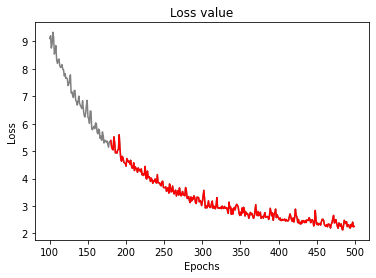

<Figure size 432x288 with 0 Axes>

In [51]:
loss=history.history['loss']
epochs=range(len(loss))

plt.plot(epochs[100:], loss[100:], 'grey')
plt.plot(epochs[180:], loss[180:], 'red')
plt.title('Loss value')
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.figure()

## Gráfico de MAE

Como podemos notar en la gráfica, vemos como iniciamos con un mae mayor a 5, mientras que a partir del epoch 150 empieza a disminuir el loss a un valor menor a 6 cumpliendo con el objetivo de la práctica.

<Figure size 432x288 with 0 Axes>

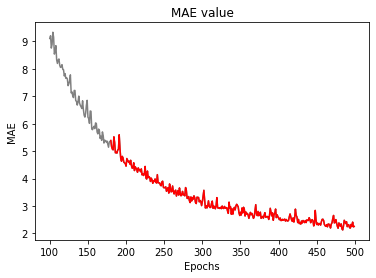

<Figure size 432x288 with 0 Axes>

In [52]:
mae=history.history['mae']
epochs=range(len(loss))

plt.plot(epochs[100:], loss[100:], 'grey')
plt.plot(epochs[180:], loss[180:], 'red')
plt.title('MAE value')
plt.xlabel("Epochs")
plt.ylabel("MAE")

plt.figure()

## Loss vs MAE

Podemos ver como existe una pequeña diferencia entre el loss y en el MAE en la primera gráfica, sin embargo, si hacemos un acercamiento a los últimos epochs podemos ver como hay una diferencia más notable, pero también podemos notar como el valor de loss y mae es menor a 5

<Figure size 432x288 with 0 Axes>

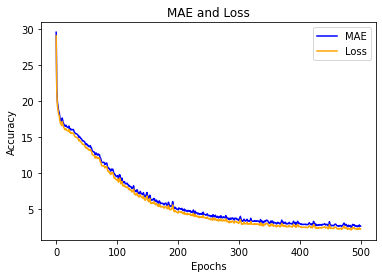

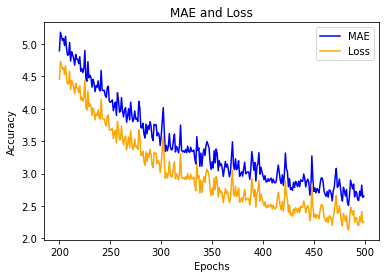

<Figure size 432x288 with 0 Axes>

In [65]:
plt.plot(epochs, mae, 'blue')
plt.plot(epochs, loss, 'orange')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'blue')
plt.plot(epochs_zoom, loss_zoom, 'orange')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

## Predicciones

Por último realizamos un método para realizar la gráfica de predicciones y datos reales. Ademas de ello realizamos un pequeño suavizado a los datos mediante un forecast. Por último realizamos la gráfica y obtenemos el siguiente resultado.

In [58]:
# The function to plot series data
def plotter(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time (Months)")
    plt.ylabel("Sunspots")
    plt.grid(True)

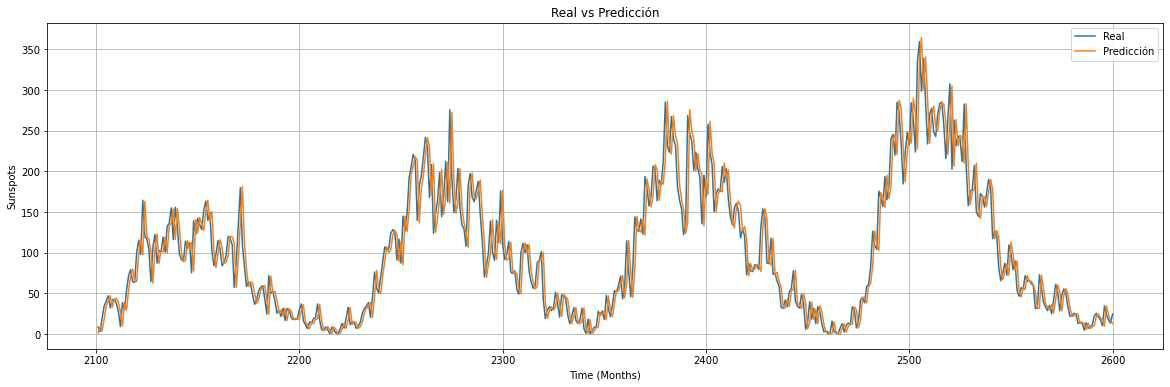

In [62]:
forecast = model.predict(test)
forecast = forecast[:, -1, 0]

time_valid = time[window_size+1:]
series_ori = series[window_size+1:]
forecast = np.reshape(forecast, (-1))
forecast = forecast[:-1]
plt.figure(figsize=(20, 6))
plotter(time_valid[2000:2500], series_ori[2000:2500])
plotter(time_valid[2000:2500], forecast[2000:2500])
plt.title('Real vs Predicción')
plt.legend(["Real", "Predicción"])

# Y finalmente, se logro predecir bien?

<div class="alert alert-success">
    <b>Si se logo, sin embargo, se puede mejorar!!</b> <br>
    Podemos utilizar técnicas de optimización mediante hyperparametros con la finalidad de optimizar nuestro modelo de red neuronal con el objetivo de mejorar nuestras métricas. Ademas ello, podemos utilizar cross-validation para obtener una mejor precisión de nuestra métrica.
</div>